# Signal Processing Project

Authors: Julian Nunez Nova, Kirill Savin


## Section 1: Introduction and Objective
Can we separate “periodic/tonal” urban sounds from “broadband/impulsive/noise-like” urban sounds using classic signal processing features?

## Section 2: Dataset and Class Grouping

This project uses the UrbanSound8K dataset, which contains 8,732 short audio clips
of urban sounds organized into 10 semantic classes such as dog barking, sirens,
engine idling, and drilling. Each clip has a maximum duration of four seconds and
is sampled at 44.1 kHz.

Rather than performing multi-class sound classification, this project reframes
the dataset from a signal processing perspective by grouping sounds according to
their dominant temporal and spectral characteristics.

The original dataset contains the following 10 classes:

- dog_bark
- children_playing
- car_horn
- air_conditioner
- street_music
- gun_shot
- siren
- engine_idling
- jackhammer
- drilling

For the purposes of this study, the original semantic labels were regrouped based
on the dominant signal characteristics of each sound. Specifically, sounds were
categorized as either:

- **Periodic / quasi-periodic**, characterized by repetitive temporal structure
  and strong spectral components; or
- **Broadband / impulsive**, characterized by short-duration events or energy
  distributed across a wide range of frequencies.


### Periodic / Quasi-Periodic Sounds

The following classes were grouped as periodic or quasi-periodic due to their
stable or repeating temporal structure:

- air_conditioner
- engine_idling
- drilling
- jackhammer
- siren

### Broadband / Impulsive Sounds

The following classes were grouped as broadband or impulsive, as they typically
exhibit irregular temporal structure and energy spread across many frequencies:

- dog_bark
- gun_shot
- children_playing


### Excluded Classes

The classes *car_horn* and *street_music* were excluded from this analysis.
Although both contain tonal components, their signal characteristics are highly
variable and context-dependent. Including these classes would blur the distinction
between periodic and broadband signals, making it more difficult to isolate the
effects of temporal periodicity.

This exclusion was therefore a deliberate design choice to preserve a clean and
interpretable comparison focused on signal structure rather than semantic content.

### Label Definition

Each audio clip was assigned a binary label indicating whether it exhibits strong
periodic temporal structure:

- **Label = 1**: Periodic or quasi-periodic sound
- **Label = 0**: Broadband or impulsive sound

The labels represent signal properties rather than sound source identity. The goal
is to assess whether classical signal processing techniques can capture this
distinction.

In [27]:
# Experiment parameters (acts as in-notebook config)

SAMPLE_RATE = 22050        # Hz
CLIP_DURATION = 2.0        # seconds
SAMPLES_PER_CLASS = 80     # limit for speed and balance
RANDOM_SEED = 42

PERIODIC_CLASSES = [
    "air_conditioner",
    "engine_idling",
    "drilling",
    "jackhammer",
    "siren"
]

BROADBAND_CLASSES = [
    "dog_bark",
    "gun_shot",
    "children_playing"
]


### Experimental Parameters and Design Choices

All audio clips were processed using a fixed set of parameters to ensure fair and
comparable signal analysis across classes.

The audio was resampled to **22.05 kHz**, which is sufficient to capture the
frequency content of urban sounds while reducing computational cost. Most relevant
energy for environmental and mechanical sounds lies well below the Nyquist frequency
of 11 kHz at this sampling rate.

Each clip was standardized to a duration of **2.0 seconds** by extracting a centered
segment and applying padding or truncation as needed. This ensures consistent time
support for autocorrelation, spectral, and time–frequency feature extraction while
preserving enough temporal context to observe periodic structure.

To maintain a balanced and computationally efficient dataset, a fixed number of
**80 samples per class** was randomly selected. This provides sufficient data to
observe statistical trends and evaluate feature separability without unnecessary
processing overhead.

A fixed **random seed** was used to ensure reproducibility of the dataset selection
and experimental results. This guarantees that the same audio clips are selected
across runs, allowing results to be consistently reproduced and verified.


## 3. Signal Processing Background

This section introduces the signal processing tools used in this project and
explains how each method relates to the distinction between periodic and broadband
urban sounds.

### 3.1 Time-Domain Representation and Autocorrelation

An audio signal can be represented as a discrete-time waveform, where the amplitude
of the signal is sampled at regular intervals. Periodic or quasi-periodic sounds
exhibit repeating patterns in the time domain, whereas broadband or impulsive sounds
do not.

Autocorrelation measures the similarity of a signal with a time-shifted version of
itself. For a signal \( x[n] \), the autocorrelation function is defined as:

\[
R_{xx}[k] = \sum_n x[n] \, x[n-k]
\]

If a signal contains periodic structure, the autocorrelation function exhibits
distinct peaks at time lags corresponding to the repetition period. In contrast,
broadband or impulsive signals tend to produce weaker and less regular autocorrelation
patterns. Autocorrelation is therefore a natural tool for detecting temporal
periodicity in audio signals.

---

### 3.2 Frequency-Domain Representation and Fourier Analysis

While the time-domain representation shows how a signal evolves over time, the
frequency-domain representation reveals how the signal’s energy is distributed across
frequencies.

The Discrete Fourier Transform (DFT), efficiently computed using the Fast Fourier
Transform (FFT), decomposes a signal into its frequency components. Periodic sounds
typically exhibit concentrated energy at specific frequencies and their harmonics,
resulting in sharp spectral peaks. Broadband sounds, on the other hand, tend to spread
energy across a wide range of frequencies, producing flatter spectra.

Spectral features such as centroid, bandwidth, roll-off, and flatness summarize these
frequency-domain characteristics and provide compact descriptors of tonal versus
noise-like behavior.

---

### 3.3 Time–Frequency Representation and Spectrograms

Many urban sounds are non-stationary, meaning their frequency content changes over
time. The Short-Time Fourier Transform (STFT) addresses this by computing the Fourier
transform over short, overlapping time windows.

The magnitude of the STFT is commonly visualized as a spectrogram, which shows how
energy is distributed across frequency and time simultaneously. Periodic or tonal
sounds often appear as stable horizontal bands in a spectrogram, while broadband or
impulsive sounds exhibit brief, wideband energy bursts or rapidly varying patterns.

Time–frequency representations therefore provide complementary information to
time-domain and frequency-domain analyses, capturing both temporal structure and
spectral evolution.


## 4. Data Loading and Preprocessing

Before extracting signal processing features, the audio data must be standardized
to ensure fair and meaningful comparisons across clips. Raw audio recordings vary
in sampling rate, duration, and amplitude, all of which can influence time-domain
and frequency-domain analyses.

In this section, audio clips are loaded, resampled, normalized, and standardized
to a fixed duration. These preprocessing steps ensure that subsequent feature
extraction reflects underlying signal structure rather than incidental recording
differences.


### Load metadata and select files:

In [28]:
import pandas as pd
import numpy as np
from pathlib import Path

# Reproducibility
np.random.seed(RANDOM_SEED)

# Paths (adjust if needed)
DATASET_PATH = Path("data/UrbanSound8K")
METADATA_PATH = DATASET_PATH / "metadata" / "UrbanSound8K.csv"

# Load metadata
metadata = pd.read_csv(METADATA_PATH)

# Filter relevant classes
selected_classes = PERIODIC_CLASSES + BROADBAND_CLASSES
metadata = metadata[metadata["class"].isin(selected_classes)]

# Sample fixed number per class
samples = (
    metadata
    .groupby("class", group_keys=False)
    .apply(lambda x: x.sample(min(len(x), SAMPLES_PER_CLASS)))
    .reset_index(drop=True)
)

# Assign binary labels
samples["label"] = samples["class"].apply(
    lambda c: 1 if c in PERIODIC_CLASSES else 0
)

samples.head()


C:\Users\julia\AppData\Local\Temp\ipykernel_19444\430665003.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), SAMPLES_PER_CLASS)))


,slice_file_name,fsID,start,end,salience,fold,classID,class,label
0,184805-0-0-104.wav,184805,52.000000,56.000000,2,6,0,air_conditioner,1
1,47160-0-0-3.wav,47160,1.556394,5.556394,1,6,0,air_conditioner,1
2,50901-0-1-0.wav,50901,9.021096,13.021096,1,1,0,air_conditioner,1
3,195969-0-0-22.wav,195969,294.485610,298.485610,2,4,0,air_conditioner,1
4,177726-0-0-28.wav,177726,14.000000,18.000000,2,8,0,air_conditioner,1


### Load and preprocess audio

In [29]:
import librosa

def load_and_preprocess_audio(path, sr, duration):
    """
    Load an audio file, resample, normalize, and fix duration.
    """
    # Load audio
    x, _ = librosa.load(path, sr=sr, mono=True)

    # Normalize amplitude
    x = x / np.max(np.abs(x)) if np.max(np.abs(x)) > 0 else x

    # Fix length
    target_length = int(sr * duration)
    if len(x) > target_length:
        start = (len(x) - target_length) // 2
        x = x[start:start + target_length]
    else:
        x = np.pad(x, (0, target_length - len(x)))

    return x


In [30]:
example_signals = []

for _, row in samples.sample(5, random_state=RANDOM_SEED).iterrows():
    audio_path = (
        DATASET_PATH /
        f"audio/fold{row['fold']}/{row['slice_file_name']}"
    )
    x = load_and_preprocess_audio(
        audio_path,
        SAMPLE_RATE,
        CLIP_DURATION
    )
    example_signals.append((x, row["class"], row["label"]))

len(example_signals)

x, cls, lbl = example_signals[0]
print(x.shape)
print(cls, lbl)
print(np.max(np.abs(x)))


(44100,)
siren 1
1.0


## 5. Autocorrelation and Spectral Analysis

In this section, classical signal processing techniques are applied to the
preprocessed audio signals. Autocorrelation is used to analyze temporal
periodicity, while Fourier-based spectral analysis is used to examine how energy
is distributed across frequencies.

These analyses provide direct insight into the structural differences between
periodic and broadband urban sounds.


In [31]:
def autocorrelation(x):
    """
    Compute normalized autocorrelation for a 1D signal.
    """
    x = x - np.mean(x)
    r = np.correlate(x, x, mode="full")
    r = r[r.size // 2:]
    return r / np.max(r)


In [32]:
import matplotlib.pyplot as plt

def plot_autocorr_example(signal, sr, title):
    r = autocorrelation(signal)
    lags = np.arange(len(r)) / sr

    plt.figure(figsize=(6, 3))
    plt.plot(lags, r)
    plt.xlim(0, 0.2)  # focus on short lags
    plt.xlabel("Lag (seconds)")
    plt.ylabel("Normalized autocorrelation")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [37]:
example_signals = []

target_classes = ["engine_idling", "gun_shot"]

for _, row in samples[samples["class"].isin(target_classes)].iterrows():
    audio_path = (
        DATASET_PATH /
        f"audio/fold{row['fold']}/{row['slice_file_name']}"
    )
    x = load_and_preprocess_audio(audio_path, SAMPLE_RATE, CLIP_DURATION)
    example_signals.append((x, row["class"], row["label"]))

len(example_signals)


160

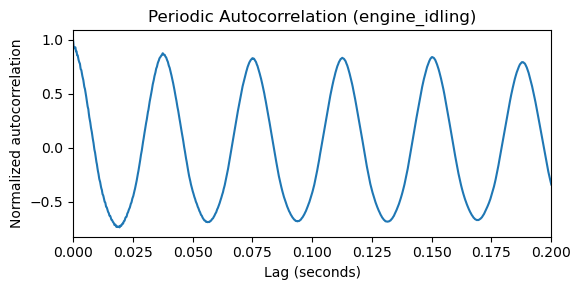

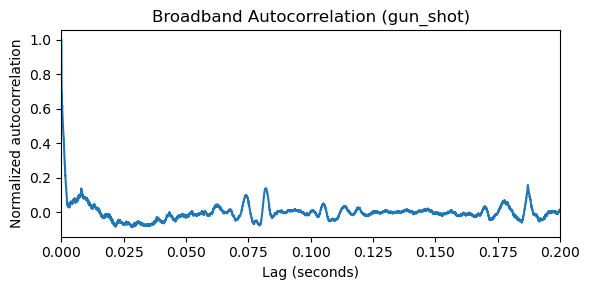

In [38]:
periodic_example = next((x, c, l) for x, c, l in example_signals if c == "engine_idling")
broadband_example = next((x, c, l) for x, c, l in example_signals if c == "gun_shot")

plot_autocorr_example(periodic_example[0], SAMPLE_RATE,
                      f"Periodic Autocorrelation ({periodic_example[1]})")

plot_autocorr_example(broadband_example[0], SAMPLE_RATE,
                      f"Broadband Autocorrelation ({broadband_example[1]})")
